# Introduction

Thats what I like is a very intresting assignment that teach us about vectore embeddings and its applications.

In this notebook we use nltk's reuters dataset and generate some vector embeddings for the vocabulary of this dataset by training skipgram, sikgram (neg) and GloVe models. 

In [ ]:
#Imports 

import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import math
import re
from nltk.corpus import reuters
from scipy.stats import spearmanr
import pandas as pd
import random 
import time
import gensim.downloader as api
import pickle
import json
import os

In [ ]:
# #Optional: download NLTK data the first time you run this notebook
# #If getting path related erros delete the donload_dir argument to use the default NLTK data folder

# nltk.download('reuters', download_dir='./data')
# nltk.download('punkt', download_dir='./data')
# nltk.download('stopwords', download_dir='./data')

# Load Data

Load the Reuters corpus from NLTK, inspect the number of documents, and build a raw text corpus that will later be tokenized and numericalized.

In [ ]:
doc_ids = reuters.fileids() # get reyters document IDs
print('Total documents:', len(doc_ids)) #print total number of documents
print('Sample document IDs:', doc_ids[:5]) #print sample document IDs

corpus_raw = [] #list to hold preprocessed documents
for doc_id in doc_ids:  
    text = reuters.raw(doc_id)
    text = text.lower()
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    corpus_raw.append(text) #append preprocessed document to corpus_raw

len(corpus_raw)

Total documents: 10788
Sample document IDs: ['test/14826', 'test/14828', 'test/14829', 'test/14832', 'test/14833']


10788

# Prepare Data

Preprocess the raw Reuters text into a form suitable for training:

- Tokenize documents into word sequences.
- Build the vocabulary and mappings `word2index` / `index2word`.
- Precompute skip-gram pairs with a configurable window size so training batches can be sampled efficiently later.

In [4]:
# Tokenization (simple whitespace split)
corpus = [sent.split(' ') for sent in corpus_raw]

# Vocabulary and mappings
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus)))
vocabs = vocabs + ['<UNK>']
word2index = {word: idx for idx, word in enumerate(vocabs)}
index2word = {idx: word for word, idx in word2index.items()}

len(vocabs)

73250

In [5]:
skip_grams = []

for doc in corpus:
    for i in range(1, len(doc)-1):
        center = doc[i]
        outside = [doc[i-1], doc[i+1]]
        for each_out in outside:
            skip_grams.append((center, each_out))
skip_grams[:5]

[('exporters', 'asian'),
 ('exporters', 'fear'),
 ('fear', 'exporters'),
 ('fear', 'damage'),
 ('damage', 'fear')]

# Models

Define the neural models used in this assignment, keeping them consistent with the lecture notes:

- **Skip-gram (full softmax)** for predicting context words from a center word.
- **Skip-gram with Negative Sampling** following the negative-sampling formulation from the Word2Vec lecture.
- **GloVe** following the GloVe-from-scratch lecture, with separate center/outside embeddings and biases.

### Skipgram Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [ ]:
class Skipgram(nn.Module):
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)

    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)          # (batch_size, 1, emb_size)
        outside_embedding    = self.embedding_outside(outside)        # (batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_outside(all_vocabs)     # (batch_size, voc_size, emb_size)

        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        lower_term = torch.sum(torch.exp(all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)), 1) # (batch_size, 1)
        log_prob = (top_term / lower_term).log()  # (batch_size, 1) log P(o|c) for each example

        # For training we want a single scalar loss,
        # so we minimize the negative mean log-likelihood.
        loss = -log_prob.mean()
        return loss  # scalar

### Skipgram Negative

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [7]:
class SkipgramNeg(nn.Module):
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()

    def forward(self, center, outside, negative):
        # center, outside: (batch_size, 1)
        # negative       : (batch_size, K)
        center_embeds   = self.embedding_center(center)          # (batch_size, 1, emb_size)
        outside_embeds  = self.embedding_outside(outside)        # (batch_size, 1, emb_size)
        negative_embeds = self.embedding_outside(negative)       # (batch_size, K, emb_size)
        uovc      = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)   # (batch_size, 1)
        ukvc      = -negative_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2) # (batch_size, K)
        ukvc_sum  = torch.sum(ukvc, 1).reshape(-1, 1)                                # (batch_size, 1)
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        return -torch.mean(loss)

### GloVe

$$
\mathbf{J}_{\text{GloVe}}
=
\sum_{i,j=1}^{V}
f(X_{ij})
\left(
\mathbf{w}_i^{T}\tilde{\mathbf{w}}_j
+
b_i
+
\tilde{b}_j
-
\log X_{ij}
\right)^2
$$


In [8]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

# Utils (Training, Evaluation, Visualization)

Helper functions for batching, training each model, evaluating analogies, and computing similarity correlations.

In [ ]:
# Common hyperparameters
batch_size = 2
emb_size = 2
lr = 0.001
num_epochs = 10

# Batching for full-softmax Skip-gram
def random_batch(batch_size, corpus, window=2):
    inputs = [] #center words
    labels = [] #context words

    while len(inputs) < batch_size:
        doc = random.choice(corpus) #randomly select a document
        if len(doc) < 2 * window + 1: 
            continue

        center_pos = random.randint(window, len(doc) - window - 1) #random center word position
        center_word = word2index[doc[center_pos]] #get center word index

        context_positions = list(range(center_pos - window, center_pos + window + 1))  #context word positions
        context_positions.remove(center_pos) #remove center word position

        context_pos = random.choice(context_positions) #randomly select a context word position
        context_word = word2index[doc[context_pos]] #get context word index

        inputs.append([center_word]) 
        labels.append([context_word])

    return np.array(inputs), np.array(labels)

#### Negative Sampling
$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [ ]:
z = 0.001

word_count = Counter(flatten(corpus))

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words


unigram_table = []

for v in vocabs:    # create unigram table for negative sampling
    uw = word_count[v] / num_total_words #
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)
    
Counter(unigram_table)

def prepare_sequence(seq, word2index): # prepare sequence of words to tensor of word indices
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)


def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

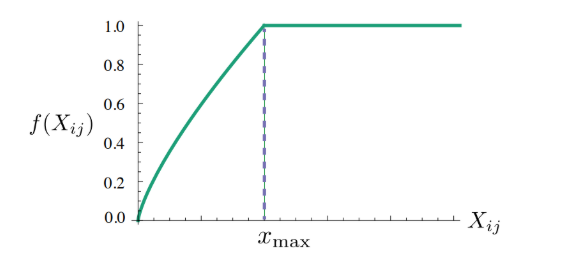


In [11]:
X_ik_skipgrams = Counter(skip_grams)


# Build the co-occurrence dictionary X_ik only for word pairs
 # that actually appear as skip-grams in the corpus.
# This avoids constructing the full |V| x |V| matrix, which would
 # require huge amounts of memory and cause a memory error.
def weighting(w_i, w_j, X_ik):
    # Look up the co-occurrence count for (w_i, w_j).
    # If the pair never appears, fall back to 1 (Laplace smoothing).
    x_ij = X_ik.get((w_i, w_j), 1)

    # GloVe weighting function hyperparameters.
    x_max = 100
    alpha = 0.75

    # If co-occurrence does not exceed x_max, down-weight with a power.
    if x_ij < x_max:
        result = (x_ij / x_max) ** alpha
    else:
        # Otherwise, cap the weight at 1.
        result = 1
    return result

# X_ik: stores (center, context) -> co-occurrence count (+1 for stability).
# weighting_dic: stores (center, context) -> f(X_ij) given by the weighting function.
X_ik = {}
weighting_dic = {}

# Fill X_ik using only observed skip-gram co-occurrences.
# For each observed bigram, we add both (w_i, w_j) and (w_j, w_i) so
 # that the matrix is symmetric, as is common for GloVe training.
for bigram, co in X_ik_skipgrams.items():
    w_i, w_j = bigram
    # +1 for numerical stability (avoids log(0) later).
    X_ik[(w_i, w_j)] = co + 1
    X_ik[(w_j, w_i)] = co + 1

# Pre-compute the weighting factor for every co-occurring pair in X_ik.
# This keeps memory usage proportional to the number of observed
 # co-occurrences rather than |V|^2.
for (w_i, w_j) in X_ik.keys():
    weighting_dic[(w_i, w_j)] = weighting(w_i, w_j, X_ik)

In [ ]:
def random_batch_glove(batch_size, corpus, X_ik, weighting_dic, window=2):
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []

    while len(random_inputs) < batch_size: # while we don't have enough samples
        doc = random.choice(corpus) # randomly select a document
        if len(doc) < 2 * window + 1: # if document is too short, skip
            continue

        center_pos = random.randint(window, len(doc) - window - 1) # random center word position
        center_word = doc[center_pos] # get center word

        context_positions = list(range(center_pos - window, center_pos + window + 1)) # get context word positions
        context_positions.remove(center_pos) # remove center word position
        context_pos = random.choice(context_positions) # randomly select a context word position
        context_word = doc[context_pos] # get context word

        i = word2index[center_word] # get indices
        j = word2index[context_word] # get indices
        pair = (center_word, context_word) # word pair

        cooc = X_ik.get(pair, 1) # get co-occurrence count
        weight = weighting_dic.get(pair, 1.0) # get weighting

        random_inputs.append([i])
        random_labels.append([j])
        random_coocs.append([math.log(cooc)])
        random_weightings.append([weight])

    return (
        np.array(random_inputs),
        np.array(random_labels),
        np.array(random_coocs),
        np.array(random_weightings),
    )


In [13]:
random_batch_glove(batch_size, corpus, X_ik, weighting_dic, window=2)

(array([[18029],
        [28481]]),
 array([[40488],
        [23627]]),
 array([[3.21887582],
        [1.60943791]]),
 array([[0.35355339],
        [0.10573713]]))

In [ ]:


def train_skipgram(num_epochs, lr=0.001, batch_size=2, window_size=2, emb_size=32, corpus=corpus, vocabs=vocabs):
    model = Skipgram(len(vocabs), emb_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, len(vocabs))
    losses = []
    epoch_times = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
    #get batch
        input_batch, label_batch = random_batch(batch_size, corpus, window=window_size)
        input_tensor = torch.LongTensor(input_batch)
        label_tensor = torch.LongTensor(label_batch)
    
    #predict
        loss = model(input_tensor, label_tensor, all_vocabs)
    
    #backprogate
        optimizer.zero_grad()
        loss.backward()
    
    #update alpha
        optimizer.step()
        
    #log loss
        losses.append(loss.item())
    #log epoch time
        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)
        
    #print the loss
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")
            
    train_time = time.time() - start_time
    emb = model.embedding_center.weight.data.cpu()
    emb_norm = F.normalize(emb, dim=1)
    return model, emb_norm, losses, train_time, epoch_times

In [15]:
def train_skipgram_neg(num_epochs, lr=0.001, k=5, batch_size=2, window_size=2, emb_size=32, corpus=corpus, vocabs=vocabs, unigram_table=unigram_table):
    model = SkipgramNeg(len(vocabs), emb_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    epoch_times = []
    start_time = time.time()

    for epoch in range(num_epochs):
    #get batch
        epoch_start = time.time()
        input_batch, label_batch = random_batch(batch_size, corpus,window=window_size)
        input_tensor = torch.LongTensor(input_batch)
        label_tensor = torch.LongTensor(label_batch)
    
    #predict
        neg_samples = negative_sampling(label_tensor, unigram_table, k)
        loss = model(input_tensor, label_tensor, neg_samples)
    
    #backprogate
        optimizer.zero_grad()
        loss.backward()
    
    #update alpha
        optimizer.step()
    
    #log loss
        losses.append(loss.item())
    #log epoch time
        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)
    #print the loss
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")
            
    train_time = time.time() - start_time
    emb = model.embedding_center.weight.data.cpu()
    emb_norm = F.normalize(emb, dim=1)
    return model, emb_norm, losses, train_time, epoch_times

In [ ]:
def train_glove(num_epochs, lr=0.001, batch_size=2 ,window_size = 2, emb_size=32, corpus=corpus, vocabs=vocabs):
    model = Glove(len(vocabs), emb_size)
    losses = []
    epoch_times = []
    start_time = time.time()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        #get batch
        epoch_start = time.time()
        input_batch, target_batch, cooc_batch, weighting_batch = random_batch_glove(batch_size, corpus, X_ik, weighting_dic, window=window_size)
        input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
        target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
        cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
        weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
        
        #predict
        optimizer.zero_grad()
        loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
        #backpropagate
        loss.backward()
        optimizer.step()
        #log loss
        losses.append(loss.item())
        #log epoch time
        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

    train_time = time.time() - start_time
    emb = model.center_embedding.weight.data.cpu()
    emb_norm = F.normalize(emb, dim=1)
    return model, emb_norm, losses, train_time, epoch_times

# Task 1. Training, Visualization, and Comparison

Use the models and utilities defined above to train Skip-gram, Skip-gram NEG, and GloVe on the Reuters corpus, then compare their training loss and training time.

In [17]:
num_epochs = 10000
batch_size = 64
window_size = 2
k  = 5
emb_size = 32

In [18]:
# Train all three models
print("Training Skip-gram...")
skip_model, skip_emb_norm, skip_loss, skip_time, epoch_times = train_skipgram(num_epochs, lr=0.001, batch_size=batch_size, window_size=window_size, emb_size=emb_size, corpus=corpus, vocabs=vocabs)
print(f"Training Complete: Average Loss: {sum(skip_loss)/len(skip_loss)}, Time: {skip_time}")

print("Training Skip-gram with Negative Sampling...")
neg_model, neg_emb_norm, neg_loss, neg_time, neg_epoch_times = train_skipgram_neg(num_epochs, lr=0.001, k=k, batch_size=batch_size, window_size=window_size, emb_size=emb_size, corpus=corpus, vocabs=vocabs, unigram_table=unigram_table)
print(f"Training Complete: Average Loss: {sum(neg_loss)/len(neg_loss)}, Time: {neg_time}")

print("Training GloVe...")
glove_model, glove_emb_norm, glove_loss, glove_time, glove_epoch_times = train_glove(num_epochs, lr=0.001, batch_size=batch_size, window_size=window_size, emb_size=emb_size, corpus=corpus, vocabs=vocabs)
print(f"Training Complete: Average Loss: {sum(glove_loss)/len(glove_loss)}, Time: {glove_time}")

num_epochs = len(skip_loss)

plot_data = []

for epoch in range(num_epochs):
    plot_data.append({
        'Epoch': epoch + 1,
        'Model': 'Skipgram',
        'Training Loss': skip_loss[epoch],
        'Epoch Time (s)': epoch_times[epoch]
    })
    plot_data.append({
        'Epoch': epoch + 1,
        'Model': 'Skipgram (NEG)',
        'Training Loss': neg_loss[epoch],
        'Epoch Time (s)': neg_epoch_times[epoch]
    })
    plot_data.append({
        'Epoch': epoch + 1,
        'Model': 'GloVe',
        'Training Loss': glove_loss[epoch],
        'Epoch Time (s)': glove_epoch_times[epoch]
    })

df_epochs = pd.DataFrame(plot_data)

Training Skip-gram...
Epoch   1000 | Loss: 18.869473
Epoch   2000 | Loss: 15.778690
Epoch   3000 | Loss: 14.967645
Epoch   4000 | Loss: 12.523911
Epoch   5000 | Loss: 13.813062
Epoch   6000 | Loss: 12.433749
Epoch   7000 | Loss: 10.500414
Epoch   8000 | Loss: 10.685277
Epoch   9000 | Loss: 9.170493
Epoch  10000 | Loss: 10.565838
Training Complete: Losss: 13.726706121730805, Time: 3783.494393348694
Training Skip-gram with Negative Sampling...
Epoch   1000 | Loss: 5.203779
Epoch   2000 | Loss: 5.897180
Epoch   3000 | Loss: 4.238511
Epoch   4000 | Loss: 4.355333
Epoch   5000 | Loss: 3.196975
Epoch   6000 | Loss: 3.215429
Epoch   7000 | Loss: 2.560408
Epoch   8000 | Loss: 3.066699
Epoch   9000 | Loss: 3.522816
Epoch  10000 | Loss: 2.484940
Training Complete: Losss: 4.279615342140198, Time: 230.90853428840637
Training GloVe...
Epoch   1000 | Loss: 1110.545654
Epoch   2000 | Loss: 788.516296
Epoch   3000 | Loss: 806.509399
Epoch   4000 | Loss: 741.615112
Epoch   5000 | Loss: 590.953857
Epoch

In [19]:
import pandas as pd

# Building dataframe for summary table
df_summary = (
    df_epochs
    .groupby("Model")
    .agg(
        Training_Loss=("Training Loss", "mean"),
        Training_Time=("Epoch Time (s)", "sum")
    )
    .reset_index()
)

df_summary["Window_Size"] = window_size

df_summary = df_summary[
    ["Model", "Window_Size", "Training_Loss", "Training_Time"]
]

# Append Gensim GloVe row
gensim_glove_row = pd.DataFrame([{
    "Model": "Gensim (GloVe)",
    "Window_Size": 100,
    "Training_Loss": "-",
    "Training_Time": "-"
}])

df_summary = pd.concat([df_summary, gensim_glove_row], ignore_index=True)

# 🔹 Define custom row order
model_order = {
    "Skipgram": 1,
    "Skipgram (NEG)": 2,
    "GloVe": 3,
    "GloVe (Gensim))": 4
}

# 🔹 Sort rows by the custom order
df_summary["order"] = df_summary["Model"].map(model_order)
df_summary = df_summary.sort_values("order").drop(columns="order").reset_index(drop=True)


In [20]:
df_summary

,Model,Window_Size,Training_Loss,Training_Time
0,Skipgram,2,13.726706,3783.448128
1,Skipgram (NEG),2,4.279615,230.880975
2,GloVe,2,698.010717,212.801008
3,Gensim (GloVe),100,-,-


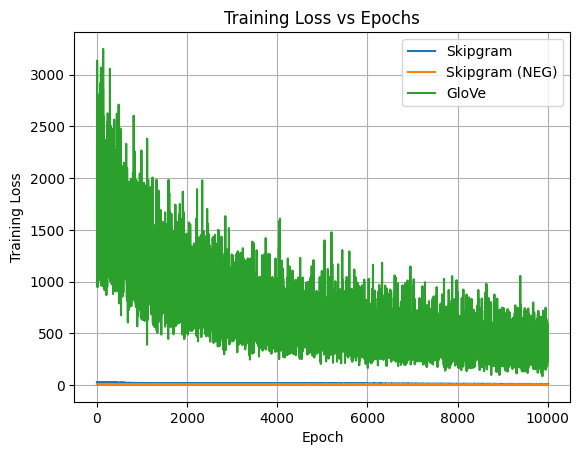

In [21]:

plt.figure()

for model in df_epochs["Model"].unique():
    subset = df_epochs[df_epochs["Model"] == model].copy()
    
    
    plt.plot(subset["Epoch"], subset["Training Loss"], label=model)

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()



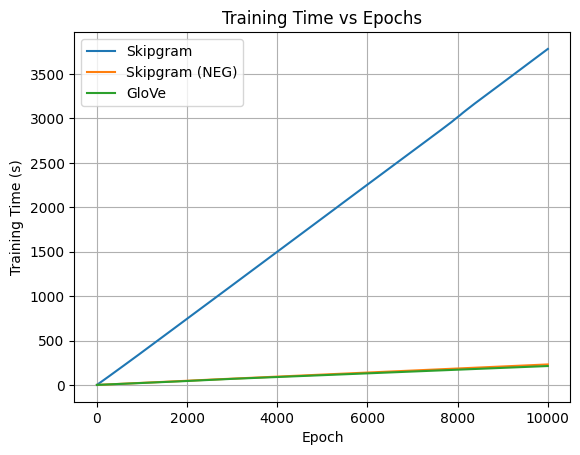

In [22]:
plt.figure()

for model in df_epochs["Model"].unique():
    subset = (
        df_epochs[df_epochs["Model"] == model]
        .sort_values("Epoch")
    )
    cum_time = subset["Epoch Time (s)"].cumsum()
    plt.plot(subset["Epoch"], cum_time, label=model)

plt.xlabel("Epoch")
plt.ylabel("Training Time (s)")
plt.title("Training Time vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


# Task 2. Model Evaluation (Analogies and Similarity)


## Expirement 1: Semantic Tests (Capital-Common-Countries)

In [23]:
def load_capital_country(filepath):
    analogies = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().lower().split()
            if len(parts) != 4:
                continue
            capital1, country1, capital2, country2 = parts
            analogies.append((capital1, country1, capital2, country2))
    return analogies


In [24]:
def predict_capital_country(cap1, country1, cap2,
                             embeddings, word2index, vocabs):
    unk = word2index.get("<unk>")

    c1 = word2index.get(cap1, unk)
    co1 = word2index.get(country1, unk)
    c2 = word2index.get(cap2, unk)

    target_vec = embeddings[co1] - embeddings[c1] + embeddings[c2]

    # normalize
    target_vec = target_vec / target_vec.norm()
    emb_norm = embeddings / embeddings.norm(dim=1, keepdim=True)

    # cosine similarities (vectorized) for master computation
    sims = emb_norm @ target_vec

    # exclude query words
    sims[c1] = -1e9
    sims[co1] = -1e9
    sims[c2] = -1e9

    return vocabs[torch.argmax(sims).item()]


In [25]:
def evaluate_capital_country(analogies, embeddings_norm, word2index, vocabs):
    correct = 0
    total = 0
    skipped = 0

    for cap1, country1, cap2, country2 in analogies:
        if any(w not in word2index for w in [cap1, country1, cap2, country2]):
            skipped += 1
            continue

        pred = predict_capital_country(
            cap1, country1, cap2,
            embeddings_norm, word2index, vocabs
        )
        
        if pred is None:
            skipped += 1
            continue

        total += 1
        if pred == country2:
            correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total, skipped

In [26]:
# Analogy utilities (capital-country, past tense)
def load_past_tense_pairs(filepath):
    analogies = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().lower().split()
            if len(parts) != 4:
                continue
            present1, past1, present2, past2 = parts
            analogies.append((present1, past1, present2, past2))
    return analogies

In [27]:
glove = api.load("glove-wiki-gigaword-100")  # 100-dim GloVe


def glove_predict_capital_country(cap1, country1, cap2, glove): # Predict using glove
    try:
        return glove.most_similar(
            positive=[country1, cap2],
            negative=[cap1],
            topn=1
        )[0][0]
    except KeyError:
        return None


def evaluate_glove_capital_country(analogies, glove): # Evaluate Glove on capital-country analogies
    correct = 0
    total = 0
    skipped = 0

    for cap1, country1, cap2, country2 in analogies:
        if any(w not in glove for w in [cap1, country1, cap2, country2]):
            skipped += 1
            continue

        pred = glove_predict_capital_country(
            cap1, country1, cap2, glove
        )

        if pred is None:
            skipped += 1
            continue

        total += 1
        if pred == country2:
            correct += 1

    acc = correct / total if total > 0 else 0
    return acc, correct, total, skipped

In [28]:
def print_eval(model, acc, acc_type): # Util function for pretty printing
    print(f"{model}")
    print(f"  {acc_type} Accuracy : {acc*100:.2f}%")
    print("-" * 40)


In [29]:


#test

capital_country = load_capital_country('data/country-capital.txt')
# Skipgram
sem_acc_skip, _, _, _ = evaluate_capital_country(capital_country, skip_emb_norm, word2index, vocabs)
print_eval("Skipgram", sem_acc_skip, "Semantic")

# Skipgram NEG
sem_acc_neg, _, _, _ = evaluate_capital_country(capital_country, neg_emb_norm, word2index, vocabs)
print_eval("Skipgram (NEG)", sem_acc_neg, "Semantic")

# Our GloVe
sem_acc_glove, _, _, _ = evaluate_capital_country(capital_country, glove_emb_norm, word2index, vocabs)
print_eval("GloVe (Our)", sem_acc_glove, "Semantic")

# Gensim GloVe
sem_acc_gs, sem_correct, sem_total, sem_skipped = evaluate_glove_capital_country(capital_country, glove)
print_eval("GloVe (Gensim)", sem_acc_gs, "Semantic")

Skipgram
  Semantic Accuracy : 0.00%
----------------------------------------
Skipgram (NEG)
  Semantic Accuracy : 0.00%
----------------------------------------
GloVe (Our)
  Semantic Accuracy : 0.00%
----------------------------------------
GloVe (Gensim)
  Semantic Accuracy : 89.44%
----------------------------------------


In [30]:
# Add semantic accuracy to summary
df_summary['Semantic Accuracy'] = [sem_acc_skip, sem_acc_neg, sem_acc_glove, sem_acc_gs]
df_summary

,Model,Window_Size,Training_Loss,Training_Time,Semantic Accuracy
0,Skipgram,2,13.726706,3783.448128,0.000000
1,Skipgram (NEG),2,4.279615,230.880975,0.000000
2,GloVe,2,698.010717,212.801008,0.000000
3,Gensim (GloVe),100,-,-,0.894433


## Expirement 2: Syntatic Tests (Past-Tense)

In [31]:
def load_past_tense_pairs(filepath):
    analogies = []

    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().lower().split()
            if len(parts) != 4:
                continue

            present1, past1, present2, past2 = parts
            analogies.append((present1, past1, present2, past2))

    return analogies

In [32]:
def predict_past_tense(present1, past1, present2,
                       embeddings_norm, word2index, vocabs):
    unk = word2index["<UNK>"]

    p1 = word2index.get(present1, unk)
    pa1 = word2index.get(past1, unk)
    p2 = word2index.get(present2, unk)

    target_vec = (
        embeddings_norm[pa1]
        - embeddings_norm[p1]
        + embeddings_norm[p2]
    )

    # normalize target
    target_vec = target_vec / target_vec.norm()

    # embeddings_norm assumed row-normalized
    sims = embeddings_norm @ target_vec

    # exclude query words
    sims[p1] = -1e9
    sims[pa1] = -1e9
    sims[p2] = -1e9

    return vocabs[torch.argmax(sims).item()]


In [33]:
def evaluate_past_tense(analogies, embeddings_norm, word2index, vocabs):
    correct = 0
    total = 0
    skipped = 0

    for present1, past1, present2, past2 in analogies:
        if any(w not in word2index for w in [present1, past1, present2, past2]):
            skipped += 1
            continue

        prediction = predict_past_tense(
            present1, past1, present2,
            embeddings_norm, word2index, vocabs
        )

        if prediction is None:
            skipped += 1
            continue

        total += 1
        if prediction == past2:
            correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total, skipped

In [34]:
def glove_predict_past_tense(present1, past1, present2, glove):
    try:
        return glove.most_similar(
            positive=[past1, present2],
            negative=[present1],
            topn=1
        )[0][0]
    except KeyError:
        return None

def evaluate_glove_past_tense(analogies, glove):
    correct = 0
    total = 0
    skipped = 0

    for present1, past1, present2, past2 in analogies:
        if any(w not in glove for w in [present1, past1, present2, past2]):
            skipped += 1
            continue

        pred = glove_predict_past_tense(
            present1, past1, present2, glove
        )

        if pred is None:
            skipped += 1
            continue

        total += 1
        if pred == past2:
            correct += 1

    acc = correct / total if total > 0 else 0
    return acc, correct, total, skipped


In [35]:
past_tense = load_past_tense_pairs('data/past-tense.txt')

# Skipgram
sen_acc_skip, _, _, _ = evaluate_past_tense(past_tense, skip_emb_norm, word2index, vocabs)
print_eval("Skipgram", sen_acc_skip, "Syntactic")

# Skipgram NEG
sen_acc_neg, _, _, _ = evaluate_past_tense(past_tense, neg_emb_norm, word2index, vocabs)
print_eval("Skipgram (NEG)", sen_acc_neg, "Syntactic")
# Our GloVe
sen_acc_glove, _, _, _ = evaluate_past_tense(past_tense, glove_emb_norm, word2index, vocabs)
print_eval("GloVe (Our)", sen_acc_glove, "Syntactic")

# Gensim GloVe
sen_acc_gs, sen_correct, sen_total, sen_skipped = evaluate_glove_past_tense(past_tense, glove)
print_eval("GloVe (Gensim)", sen_acc_gs, "Syntactic")

Skipgram
  Syntactic Accuracy : 0.00%
----------------------------------------
Skipgram (NEG)
  Syntactic Accuracy : 0.00%
----------------------------------------
GloVe (Our)
  Syntactic Accuracy : 0.00%
----------------------------------------
GloVe (Gensim)
  Syntactic Accuracy : 55.45%
----------------------------------------


In [36]:
# Add syntactic accuracy to summary
df_summary['Syntactic Accuracy'] = [sen_acc_skip, sen_acc_neg, sen_acc_glove, sen_acc_gs]
df_summary

,Model,Window_Size,Training_Loss,Training_Time,Semantic Accuracy,Syntactic Accuracy
0,Skipgram,2,13.726706,3783.448128,0.000000,0.000000
1,Skipgram (NEG),2,4.279615,230.880975,0.000000,0.000000
2,GloVe,2,698.010717,212.801008,0.000000,0.000000
3,Gensim (GloVe),100,-,-,0.894433,0.554487


## Expirement 3: Similarity Tests (Word Similarity)

In [ ]:
# Similarity correlation utilities
sim_df = pd.read_csv('data/wordsim353/combined.csv')
sim_df['Word 1'] = sim_df['Word 1'].str.lower()
sim_df['Word 2'] = sim_df['Word 2'].str.lower()

def compute_spearman(embeddings_norm):
    human_scores = []
    model_scores = []
    skipped = 0
    for _, row in sim_df.iterrows():
        w1, w2 = row['Word 1'], row['Word 2']
        if w1 not in word2index or w2 not in word2index:
            skipped += 1
            continue
        v1 = embeddings_norm[word2index[w1]]
        v2 = embeddings_norm[word2index[w2]]
        dot_sim = torch.dot(v1, v2).item()
        human_scores.append(row['Human (mean)'])
        model_scores.append(dot_sim)
    rho, p_value = spearmanr(human_scores, model_scores)
    return rho, p_value, skipped

In [38]:
# Similarity correlations for our models
rho_skip, p_skip, skipped_skip = compute_spearman(skip_emb_norm)
rho_neg, p_neg, skipped_neg = compute_spearman(neg_emb_norm)
rho_glove, p_glove, skipped_glove = compute_spearman(glove_emb_norm)

print('Skipgram Spearman:', rho_skip, 'p=', p_skip)
print('Skipgram NEG Spearman:', rho_neg, 'p=', p_neg)
print('Our GloVe Spearman:', rho_glove, 'p=', p_glove)

# Compute Spearman for Gensim GloVe
def compute_spearman_gensim(glove_model):
    """Compute Spearman correlation for Gensim GloVe model."""
    human_scores = []
    model_scores = []
    skipped = 0
    
    for _, row in sim_df.iterrows():
        w1, w2 = row['Word 1'], row['Word 2']
        if w1 not in glove_model or w2 not in glove_model:
            skipped += 1
            continue
        
        # Gensim's similarity is cosine similarity
        sim = glove_model.similarity(w1, w2)
        human_scores.append(row['Human (mean)'])
        model_scores.append(sim)
    
    rho, p_value = spearmanr(human_scores, model_scores)
    return rho, p_value, skipped

rho_gs, p_gs, skipped_gs = compute_spearman_gensim(glove)
print('Gensim GloVe Spearman:', rho_gs, 'p=', p_gs)

Skipgram Spearman: 0.010459402276834876 p= 0.8757400715564936
Skipgram NEG Spearman: 0.05955566970456412 p= 0.3728515439596664
Our GloVe Spearman: -0.029025536567107036 p= 0.6642729315251487
Gensim GloVe Spearman: 0.5327354323238274 p= 2.865414658055901e-27


In [39]:
# Add Spearman correlation to summary
df_summary['Spearman Correlation'] = [rho_skip, rho_neg, rho_glove, rho_gs]
df_summary

,Model,Window_Size,Training_Loss,Training_Time,Semantic Accuracy,Syntactic Accuracy,Spearman Correlation
0,Skipgram,2,13.726706,3783.448128,0.000000,0.000000,0.010459
1,Skipgram (NEG),2,4.279615,230.880975,0.000000,0.000000,0.059556
2,GloVe,2,698.010717,212.801008,0.000000,0.000000,-0.029026
3,Gensim (GloVe),100,-,-,0.894433,0.554487,0.532735


# Exporting Embeddings and Corpus

In [40]:
def export_embeddings(embeddings, word2index, index2word, model_name='best_model'): # Export enbeddings and vocab
    import os, json, pickle, numpy as np, torch

    os.makedirs('exports', exist_ok=True)

    # ensure numpy format
    emb = embeddings.cpu().numpy() if torch.is_tensor(embeddings) else embeddings

    emb_path = f'exports/{model_name}_embeddings.npy'
    np.save(emb_path, emb)

    vocab_path = f'exports/{model_name}_vocab.pkl'
    with open(vocab_path, 'wb') as f:
        pickle.dump({
            'word2index': word2index,
            'index2word': index2word,
            'vocab_size': len(word2index),
            'embedding_dim': emb.shape[1]
        }, f)

    vocab_json_path = f'exports/{model_name}_vocab.json'
    with open(vocab_json_path, 'w', encoding='utf-8') as f:
        json.dump({
            'word2index': word2index,
            'vocab_size': len(word2index),
            'embedding_dim': int(emb.shape[1])
        }, f, indent=2)

    return {
        'embeddings': emb_path,
        'vocab_pkl': vocab_path,
        'vocab_json': vocab_json_path
    }


def export_corpus(corpus_raw, corpus_tokenized, doc_ids): # Export corpus data  

    os.makedirs('exports', exist_ok=True)

    corpus_path = 'exports/reuters_corpus.pkl'
    with open(corpus_path, 'wb') as f:
        pickle.dump({
            'raw': corpus_raw,
            'tokenized': corpus_tokenized,
            'doc_ids': doc_ids,
            'num_docs': len(corpus_raw)
        }, f)

    # lightweight JSON for quick inspection
    corpus_json_path = 'exports/reuters_corpus_sample.json'
    with open(corpus_json_path, 'w', encoding='utf-8') as f:
        json.dump({
            'num_docs': len(corpus_raw),
            'sample_docs': [
                {
                    'doc_id': doc_ids[i],
                    'raw_text': corpus_raw[i][:200] + '...',
                    'num_tokens': len(corpus_tokenized[i])
                }
                for i in range(min(10, len(corpus_raw)))
            ]
        }, f, indent=2)

    return {
        'corpus_pkl': corpus_path,
        'corpus_json': corpus_json_path
    }


In [41]:
models_to_export = {
    "skipgram": skip_emb_norm,
    "skipgram_neg": neg_emb_norm,
    "glove": glove_emb_norm
}
all_export_paths = {}

for model_name, embeddings in models_to_export.items():
    print(f"Exporting embeddings for {model_name}...")
    paths = export_embeddings(
        embeddings,
        word2index,
        index2word,
        model_name=model_name
    )
    all_export_paths[model_name] = paths


Exporting embeddings for skipgram...
Exporting embeddings for skipgram_neg...
Exporting embeddings for glove...
